# ATML Assignment 4

## Setup:

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Device:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

#### Getting Datasets

In [ ]:
def get_datasets(num_clients):
    """
    Loads MNIST and splits it for centralized and federated settings.
    For Task 1, we create an IID, equal-sized split.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(
        './data', train=True, download=True, transform=transform
    )
    centralized_dataset = train_dataset
    num_samples = len(train_dataset)
    samples_per_client = num_samples // num_clients
    indices = np.random.permutation(num_samples)
    client_datasets = []
    for i in range(num_clients):
        client_indices = indices[i * samples_per_client : (i + 1) * samples_per_client]
        client_datasets.append(Subset(train_dataset, client_indices))
    return centralized_dataset, client_datasets

#### Small Model

In [4]:
class SmallModel(nn.Module):
    def __init__(self):
        super(SmallModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## Client Class:

In [ ]:
class Client:
    """Represents an FL client."""
    def __init__(self, client_id, model, dataloader, learning_rate, device):
        self.client_id = client_id
        self.dataloader = dataloader
        self.learning_rate = learning_rate
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def local_train(self, global_model_state, local_epochs):
        """Performs local training for K epochs. K=1 for FedSGD, and K > 1 for FedAvg."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        for epoch in range(local_epochs):
            for data, target in self.dataloader:
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
        return self.model.state_dict()

## Server Class:

In [ ]:
class Server:
    """Represents the Central Server."""
    def __init__(self, global_model, client_data_sizes, device):
        self.device = device
        self.global_model = global_model.to(self.device)
        total_data = sum(client_data_sizes)
        self.client_weights = [size / total_data for size in client_data_sizes]

    def aggregate(self, client_model_states):
        """Performs Federated Averaging (FedAvg)."""
        global_state_dict = self.global_model.state_dict()

        for key in global_state_dict:
            global_state_dict[key] = torch.zeros_like(global_state_dict[key])

        for i, state_dict in enumerate(client_model_states):
            for key in global_state_dict:
                global_state_dict[key] += state_dict[key] * self.client_weights[i]

        self.global_model.load_state_dict(global_state_dict)

    def train_round(self, clients, local_epochs):
        """Simulates one full communication round."""
        client_model_states = []
        global_model_state = copy.deepcopy(self.global_model.state_dict())
        for client in clients:
            local_model_state = client.local_train(global_model_state, local_epochs)
            client_model_states.append(local_model_state)
        self.aggregate(client_model_states)
        return self.global_model.state_dict()

In [ ]:
def compare_models(model1, model2):
    """Calculates the L2 norm of the difference between model parameters."""
    diff = 0.0
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        diff += torch.sum((param1 - param2) ** 2).item()
    return np.sqrt(diff)

## Task 1: FedSGD vs Centralized SGD (Theoretical Equivalence)

In [ ]:
# Hyperparas
NUM_CLIENTS = 3
NUM_ROUNDS = 10
LEARNING_RATE = 0.01

In [ ]:
print(f"\nTask 1: FedSGD vs Centralized SGD Equivalence")
print(f"Model: SmallModel (2 Conv, 1 FC)")
print(f"Clients: {NUM_CLIENTS}, Rounds: {NUM_ROUNDS}, LR: {LEARNING_RATE}\n")

centralized_dataset, client_datasets = get_datasets(NUM_CLIENTS)
# 1. Centralized loader:
centralized_loader = DataLoader(
    centralized_dataset, batch_size=len(centralized_dataset), shuffle=False
)
# 2. Client loaders:
client_loaders = [
    DataLoader(ds, batch_size=len(ds), shuffle=False) for ds in client_datasets
]
client_data_sizes = [len(ds) for ds in client_datasets]


Task 1: FedSGD vs Centralized SGD Equivalence
Model: SmallModel (2 Conv, 1 FC)
Clients: 3, Rounds: 10, LR: 0.01



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]


In [ ]:
initial_model = SmallModel()
centralized_model = copy.deepcopy(initial_model).to(device)
fedsgd_global_model = copy.deepcopy(initial_model).to(device)

In [ ]:
centralized_optimizer = optim.SGD(centralized_model.parameters(), lr=LEARNING_RATE)
centralized_criterion = nn.CrossEntropyLoss()
server = Server(fedsgd_global_model, client_data_sizes, device)
clients = [
    Client(i, SmallModel(), client_loaders[i], LEARNING_RATE, device)
    for i in range(NUM_CLIENTS)
]

In [ ]:
initial_state = initial_model.state_dict()
for c in clients:
    c.model.load_state_dict(initial_state)

#### Training Loop:

In [ ]:
for t in range(NUM_ROUNDS):
    # === 1. Centralized SGD Step ===
    centralized_model.train()
    data, target = next(iter(centralized_loader))
    data, target = data.to(device), target.to(device)

    centralized_optimizer.zero_grad()
    output = centralized_model(data)
    loss_cent = centralized_criterion(output, target)
    loss_cent.backward()
    centralized_optimizer.step()
    # === 2. FedSGD Round (K=1) ===
    fedsgd_global_model.eval()
    with torch.no_grad():
        output_fed = fedsgd_global_model(data)
        loss_fed = centralized_criterion(output_fed, target)
    server.train_round(clients, local_epochs=1)
    param_diff = compare_models(centralized_model, fedsgd_global_model)
    print(f"--- Round {t+1} ---")
    print(f"Centralized Loss: {loss_cent.item():.6f}")
    print(f"FedSGD Loss:      {loss_fed.item():.6f}")
    print(f"||W_cent - W_fed|| (using L2 Norm): {param_diff:.2e}\n")

--- Round 1 ---
Centralized Loss: 2.295186
FedSGD Loss:      2.295186
||W_cent - W_fed|| (using L2 Norm): 2.45e-07

--- Round 2 ---
Centralized Loss: 2.278528
FedSGD Loss:      2.278528
||W_cent - W_fed|| (using L2 Norm): 4.41e-07

--- Round 3 ---
Centralized Loss: 2.263159
FedSGD Loss:      2.263159
||W_cent - W_fed|| (using L2 Norm): 6.97e-07

--- Round 4 ---
Centralized Loss: 2.248626
FedSGD Loss:      2.248626
||W_cent - W_fed|| (using L2 Norm): 9.27e-07

--- Round 5 ---
Centralized Loss: 2.234582
FedSGD Loss:      2.234582
||W_cent - W_fed|| (using L2 Norm): 1.10e-06

--- Round 6 ---
Centralized Loss: 2.220820
FedSGD Loss:      2.220820
||W_cent - W_fed|| (using L2 Norm): 1.27e-06

--- Round 7 ---
Centralized Loss: 2.207150
FedSGD Loss:      2.207150
||W_cent - W_fed|| (using L2 Norm): 1.45e-06

--- Round 8 ---
Centralized Loss: 2.193467
FedSGD Loss:      2.193467
||W_cent - W_fed|| (using L2 Norm): 1.66e-06

--- Round 9 ---
Centralized Loss: 2.179661
FedSGD Loss:      2.179662
||

As we can see from the logs, the losses are in perfect sync, and the norm of differences in weights is also very low (of order of $\approx $ `e-07` and `e-06` throughout the training.

In [18]:
# since i didn't store the values into list earlier, adding them into lists manually and plotting them now:
centralized_losses = [
    2.295186, 2.278528, 2.263159, 2.248626, 2.234582,
    2.220820, 2.207150, 2.193467, 2.179661, 2.165648
]
fedsgd_losses = [
    2.295186, 2.278528, 2.263159, 2.248626, 2.234582,
    2.220820, 2.207150, 2.193467, 2.179662, 2.165648
]
param_diffs_l2 = [
    2.45e-07, 4.41e-07, 6.97e-07, 9.27e-07, 1.10e-06,
    1.27e-06, 1.45e-06, 1.66e-06, 1.96e-06, 2.16e-06
]

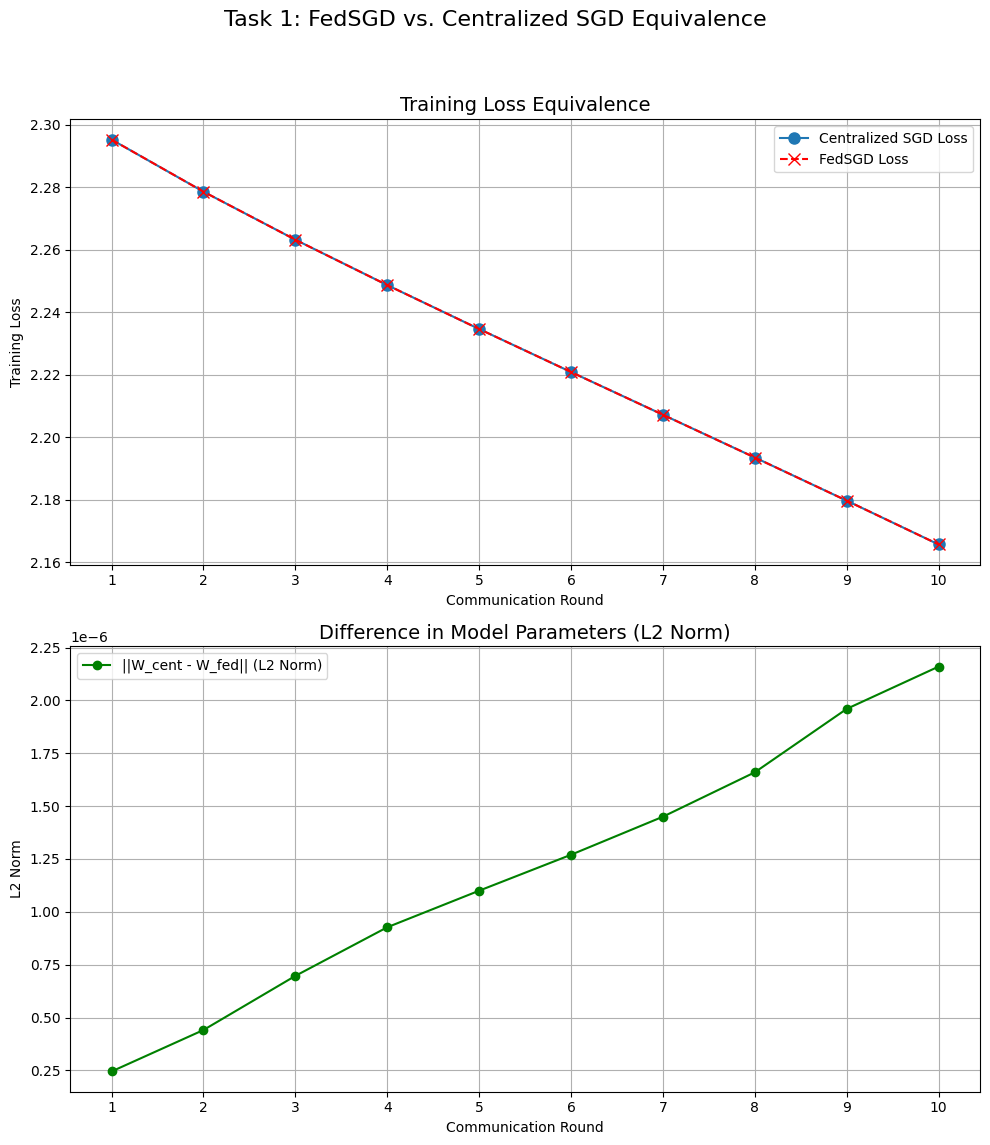

In [23]:
rounds = list(range(1, 11))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle("Task 1: FedSGD vs. Centralized SGD Equivalence", fontsize=16)

# --- Plot 1: Loss Curves ---
ax1.plot(rounds, centralized_losses, 'o-', label='Centralized SGD Loss', markersize=8)
ax1.plot(rounds, fedsgd_losses, 'x--', label='FedSGD Loss', markersize=8, color='red')
ax1.set_title('Training Loss Equivalence', fontsize=14)
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Training Loss')
ax1.legend()
ax1.grid(True)
# Use tight x-axis ticks
ax1.set_xticks(rounds)

# --- Plot 2: L2 Norm of Parameter Difference ---
ax2.plot(rounds, param_diffs_l2, 'o-', label='||W_cent - W_fed|| (L2 Norm)', color='green')
ax2.set_title('Difference in Model Parameters (L2 Norm)', fontsize=14)
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('L2 Norm')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.legend()
ax2.grid(True)
ax2.set_xticks(rounds)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Task 2: Implementing FedAvg:

In [ ]:
# same as prev., changed slightly as we don't need centralized dataset any more.
def get_client_datasets_iid(train_dataset, num_clients):
    """
    Splits the training dataset into IID, equal-sized subsets.
    """
    num_samples = len(train_dataset)
    samples_per_client = num_samples // num_clients
    indices = np.random.permutation(num_samples)
    client_datasets = []
    for i in range(num_clients):
        client_indices = indices[i * samples_per_client : (i + 1) * samples_per_client]
        client_datasets.append(Subset(train_dataset, client_indices))
    return client_datasets

#### Slightly Changed Client:

In [5]:
class Client:
    """Represents an FL client."""
    def __init__(self, client_id, model, dataset, batch_size, learning_rate, device):
        self.client_id = client_id
        self.device = device
        self.model = model.to(self.device)
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        # Each client now has its own mini-batch dataloader
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    def local_train(self, global_model_state, local_epochs):
        """Performs local training for K epochs."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        # Re-initialize optimizer
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        for epoch in range(local_epochs):
            for data, target in self.dataloader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return self.model.state_dict()

#### Slightly Changed Server:

In [6]:
class Server:
    """Represents the Central Server."""
    def __init__(self, global_model, client_data_sizes, test_loader, device):
        self.device = device
        self.global_model = global_model.to(self.device)
        self.test_loader = test_loader
        total_data = sum(client_data_sizes)
        self.client_weights = [size / total_data for size in client_data_sizes]

    def aggregate(self, client_model_states, selected_client_indices):
        """
        Performs Federated Averaging (FedAvg).
        It now aggregates ONLY the updates from selected clients,
        using their pre-calculated weights.
        """
        global_state_dict = self.global_model.state_dict()
        for key in global_state_dict:
            global_state_dict[key].zero_()
        selected_weights = [self.client_weights[i] for i in selected_client_indices]
        total_selected_weight = sum(selected_weights)
        normalized_weights = [w / total_selected_weight for w in selected_weights]
        # Accumulate weighted updates
        for i, local_state in enumerate(client_model_states):
            weight = normalized_weights[i]
            for key in global_state_dict:
                global_state_dict[key] += local_state[key] * weight

        self.global_model.load_state_dict(global_state_dict)

    def train_round(self, all_clients, local_epochs, client_sampling_fraction):
        """
        Simulates one full communication round with client sampling.
        """
        num_clients_total = len(all_clients)
        num_to_sample = int(num_clients_total * client_sampling_fraction)
        num_to_sample = max(1, num_to_sample)

        selected_client_indices = np.random.choice(
            num_clients_total, num_to_sample, replace=False
        )
        selected_clients = [all_clients[i] for i in selected_client_indices]

        # --- Local Training on Selected Clients ---
        client_model_states = []
        global_model_state = copy.deepcopy(self.global_model.state_dict())

        for client in selected_clients:
            local_model_state = client.local_train(global_model_state, local_epochs)
            client_model_states.append(local_model_state)
        avg_drift = self.calculate_client_drift(global_model_state, client_model_states)
        self.aggregate(client_model_states, selected_client_indices)
        return avg_drift

    def calculate_client_drift(self, global_state, local_states):
        """
        Calculates the average L2 norm between the global model
        and the client models *after* their local training.
        This is the metric d_theta^t from the manual[cite: 151].
        """
        total_drift = 0.0
        for local_state in local_states:
            diff = 0.0
            for key in global_state:
                # Calculate L2 norm of the difference (delta)
                diff += torch.sum((global_state[key].cpu() - local_state[key].cpu()) ** 2).item()
            total_drift += np.sqrt(diff)

        return total_drift / len(local_states)

    def evaluate(self):
        """
        Evaluates the global model on the hold-out test set.
        """
        self.global_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100.0 * correct / total
        return accuracy

In [7]:
def plot_results(results, title_prefix):
    """
    Generates the two plots required:
    1. Accuracy vs. Communication Rounds
    2. Client Drift vs. Communication Rounds
    """
    plt.figure(figsize=(20, 8))

    # Plot 1: Accuracy vs. Rounds
    plt.subplot(1, 2, 1)
    for key, (accuracies, drifts) in results.items():
        plt.plot(accuracies, label=f"{key}")
    plt.title(f"{title_prefix}: Global Test Accuracy vs. Communication Rounds")
    plt.xlabel("Communication Round")
    plt.ylabel("Global Test Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Plot 2: Client Drift vs. Rounds
    plt.subplot(1, 2, 2)
    for key, (accuracies, drifts) in results.items():
        plt.plot(drifts, label=f"{key}")
    plt.title(f"{title_prefix}: Average Client Drift vs. Communication Rounds")
    plt.xlabel("Communication Round")
    plt.ylabel("Avg. Weight Divergence (L2 Norm)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### Task 2 Setup:

In [ ]:
# Hyperpars
NUM_CLIENTS = 5
NUM_ROUNDS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 64
FIXED_K_FOR_EXP2 = 5

#### Loading Datasets:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    './data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    './data', train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
client_datasets = get_client_datasets_iid(train_dataset, NUM_CLIENTS)
client_data_sizes = [len(ds) for ds in client_datasets]

## Experiment 1:

In [ ]:
k_values = [1, 5, 10, 20]
sampling_fraction_k_exp = 1.0
results_k = {}

In [ ]:
print("--- Starting Experiment 1: Varying K ---")
for K in k_values:
    print(f"Running FedAvg with K={K}, f=1.0")
    initial_model = SmallModel()
    clients = [
        Client(i, SmallModel(), client_datasets[i], BATCH_SIZE, LEARNING_RATE, device)
        for i in range(NUM_CLIENTS)
    ]
    # Ensure all clients start from the same initial model
    initial_state = initial_model.state_dict()
    for c in clients:
        c.model.load_state_dict(initial_state)

    server = Server(initial_model, client_data_sizes, test_loader, device)

    accuracies = []
    drifts = []

    for t in range(NUM_ROUNDS):
        avg_drift = server.train_round(clients, K, sampling_fraction_k_exp)
        accuracy = server.evaluate()

        accuracies.append(accuracy)
        drifts.append(avg_drift)

        if (t + 1) % 2 == 0:
            print(f"  Round {t+1}/{NUM_ROUNDS} - Accuracy: {accuracy:.2f}% - Drift: {avg_drift:.4f}")

    results_k[f"K={K}"] = (accuracies, drifts)

--- Starting Experiment 1: Varying K ---
Running FedAvg with K=1, f=1.0
  Round 2/10 - Accuracy: 93.23% - Drift: 0.4973
  Round 4/10 - Accuracy: 95.75% - Drift: 0.2668
  Round 6/10 - Accuracy: 96.72% - Drift: 0.2003
  Round 8/10 - Accuracy: 97.24% - Drift: 0.1668
  Round 10/10 - Accuracy: 97.52% - Drift: 0.1469
Running FedAvg with K=5, f=1.0
  Round 2/10 - Accuracy: 97.69% - Drift: 0.7383
  Round 4/10 - Accuracy: 98.38% - Drift: 0.4370
  Round 6/10 - Accuracy: 98.62% - Drift: 0.3706
  Round 8/10 - Accuracy: 98.80% - Drift: 0.3426
  Round 10/10 - Accuracy: 98.90% - Drift: 0.3260
Running FedAvg with K=10, f=1.0
  Round 2/10 - Accuracy: 98.21% - Drift: 0.9241
  Round 4/10 - Accuracy: 98.70% - Drift: 0.6351
  Round 6/10 - Accuracy: 98.83% - Drift: 0.5577
  Round 8/10 - Accuracy: 98.88% - Drift: 0.5132
  Round 10/10 - Accuracy: 99.00% - Drift: 0.4802
Running FedAvg with K=20, f=1.0
  Round 2/10 - Accuracy: 98.67% - Drift: 1.1487
  Round 4/10 - Accuracy: 98.80% - Drift: 0.8126
  Round 6/10 -

## Experiment 2:

In [ ]:
f_values = [1.0, 0.5, 0.2]
k_for_f_exp = FIXED_K_FOR_EXP2
results_f = {}

In [ ]:
print("\n--- Starting Experiment 2: Varying Client Sampling Fraction ---")
for f in f_values:
    print(f"Running FedAvg with K={k_for_f_exp}, f={f}")
    initial_model = SmallModel()
    clients = [
        Client(i, SmallModel(), client_datasets[i], BATCH_SIZE, LEARNING_RATE, device)
        for i in range(NUM_CLIENTS)
    ]
    initial_state = initial_model.state_dict()
    for c in clients:
        c.model.load_state_dict(initial_state)
    server = Server(initial_model, client_data_sizes, test_loader, device)
    accuracies = []
    drifts = []
    for t in range(NUM_ROUNDS):
        avg_drift = server.train_round(clients, k_for_f_exp, f)
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        drifts.append(avg_drift)
        if (t + 1) % 10 == 0:
            print(f"  Round {t+1}/{NUM_ROUNDS} - Accuracy: {accuracy:.2f}% - Drift: {avg_drift:.4f}")
    results_f[f"f={f}"] = (accuracies, drifts)


--- Starting Experiment 2: Varying Client Sampling Fraction ---
Running FedAvg with K=5, f=1.0
  Round 10/10 - Accuracy: 98.78% - Drift: 0.3313
Running FedAvg with K=5, f=0.5
  Round 10/10 - Accuracy: 98.72% - Drift: 0.3041
Running FedAvg with K=5, f=0.2
  Round 10/10 - Accuracy: 98.71% - Drift: 0.3192


#### Plots

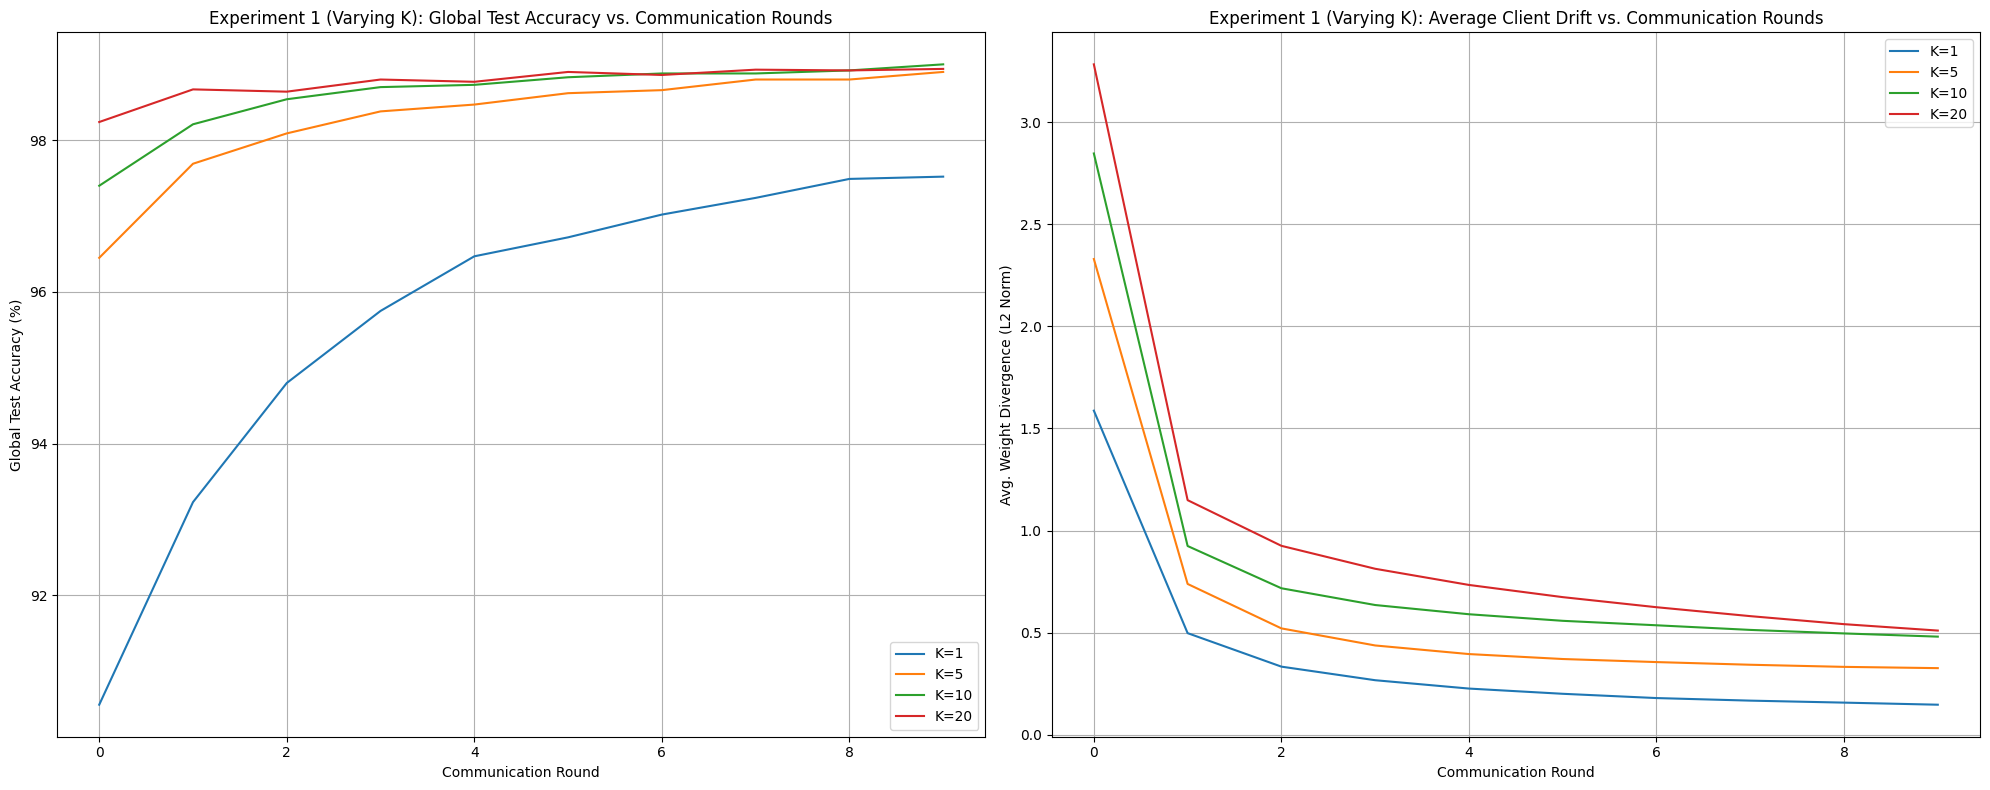

In [ ]:
plot_results(results_k, "Experiment 1 (Varying K)")

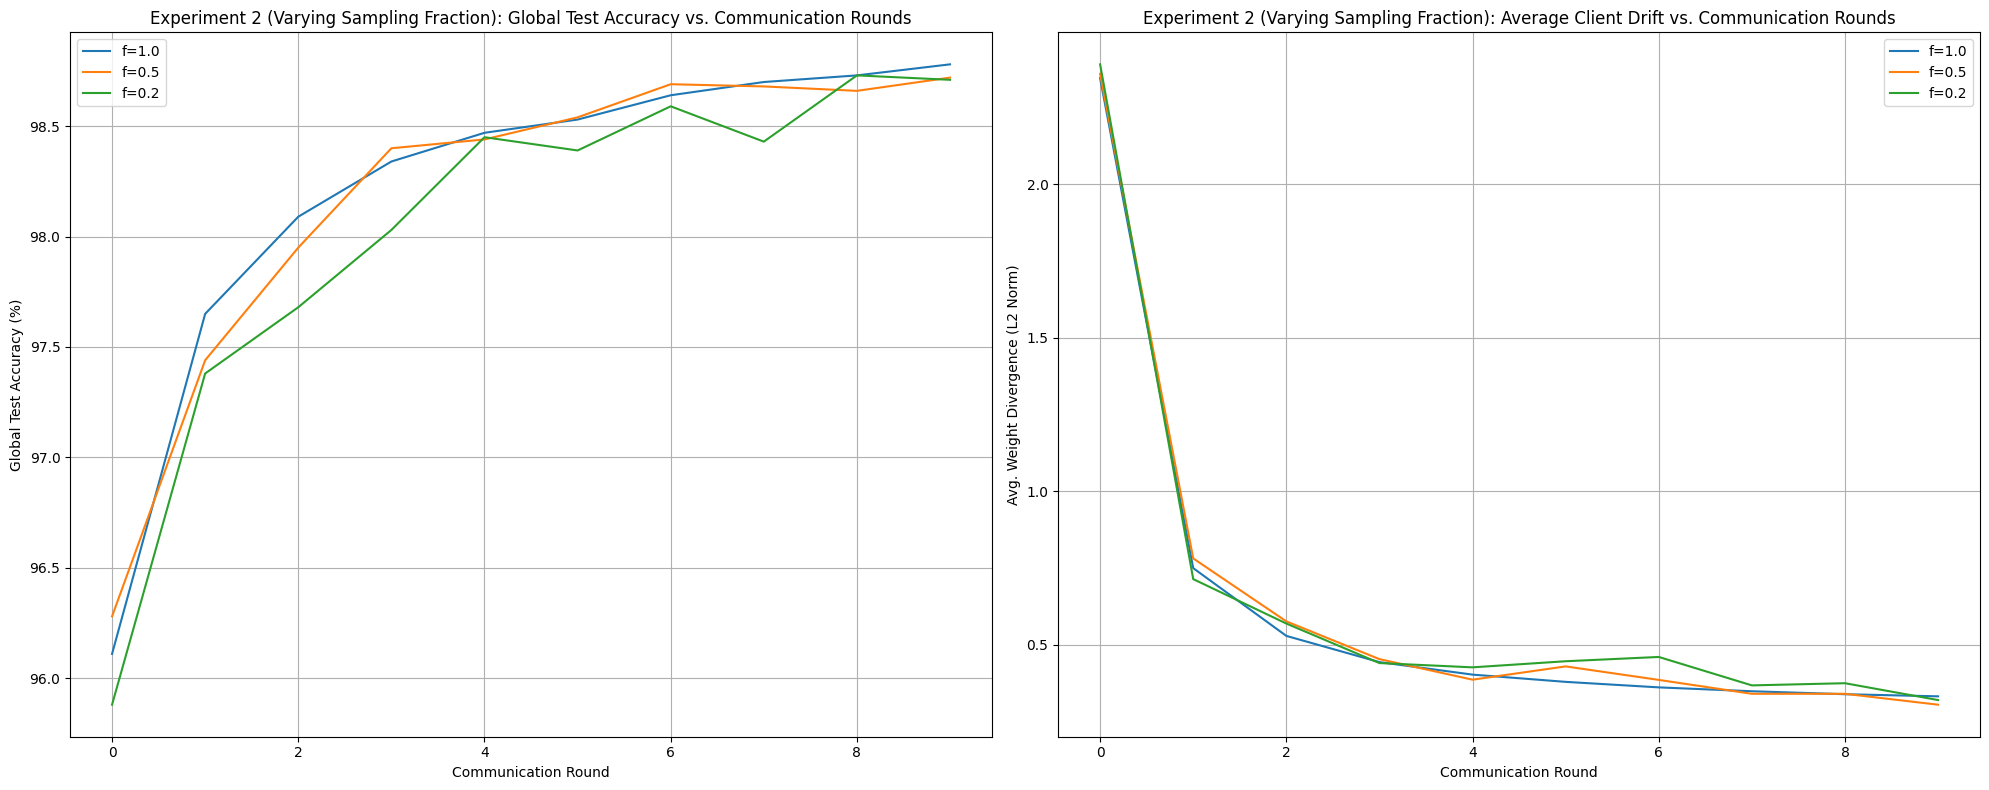

In [ ]:
plot_results(results_f, "Experiment 2 (Varying Sampling Fraction)")

In [ ]:
import torch
import os

# --- Model Saving ---

# Ensure a directory for models exists
MODEL_SAVE_DIR = "federated_models"
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)

# 1. Save the final model from Experiment 1 (Varying K)
# NOTE: The last model trained in this loop was K=20 (k_values[-1])
# We use the 'server' instance which holds the final global model state after the loop.
try:
    path_k = os.path.join(MODEL_SAVE_DIR, f"fedavg_k_{k_values[-1]}_final.pth")
    torch.save(server.global_model.state_dict(), path_k)
    print(f"Successfully saved final model from Experiment 1 to: {path_k}")
except Exception as e:
    print(f"Could not save model from Experiment 1: {e}")

# 2. Save the final model from Experiment 2 (Varying Sampling Fraction)
# NOTE: This model corresponds to f=0.2 (f_values[-1])
# The 'server' instance was overwritten in the second experiment loop.
try:
    path_f = os.path.join(MODEL_SAVE_DIR, f"fedavg_f_{f_values[-1]}_k_{k_for_f_exp}_final.pth")
    torch.save(server.global_model.state_dict(), path_f)
    print(f"Successfully saved final model from Experiment 2 to: {path_f}")
except Exception as e:
    print(f"Could not save model from Experiment 2: {e}")

Successfully saved final model from Experiment 1 to: federated_models/fedavg_k_20_final.pth
Successfully saved final model from Experiment 2 to: federated_models/fedavg_f_0.2_k_5_final.pth


## Task 3: Exploring Data Heterogeneity Impact:

In [9]:
def get_client_datasets_dirichlet(train_dataset, num_clients, alpha):
    """
    Splits the training dataset into non-IID partitions using a
    Dirichlet distribution to simulate label skew.
    """
    num_classes = 10 # For MNIST
    try:
        labels = train_dataset.targets.numpy()
    except AttributeError:
        labels = np.array([y for _, y in train_dataset])
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    client_indices_map = {i: [] for i in range(num_clients)}
    for class_idx in range(num_classes):
        indices_for_class = class_indices[class_idx]
        num_samples_for_class = len(indices_for_class)
        proportions = np.random.dirichlet([alpha] * num_clients)
        counts = (proportions * num_samples_for_class).astype(int)
        # Distribute the remainder samples (due to int rounding)
        remainder = num_samples_for_class - counts.sum()
        for i in range(remainder):
            counts[i % num_clients] += 1
        # Shuffle indices to randomize which samples go where
        np.random.shuffle(indices_for_class)
        # 4. Assign indices to clients based on proportions
        current_idx = 0
        for client_id in range(num_clients):
            num_samples_for_client = counts[client_id]
            client_indices_map[client_id].extend(
                indices_for_class[current_idx : current_idx + num_samples_for_client]
            )
            current_idx += num_samples_for_client
    # 5. Create Subset datasets
    client_datasets = [
        Subset(train_dataset, client_indices_map[i]) for i in range(num_clients)
    ]
    return client_datasets

#### Task 3 Setup:

In [13]:
NUM_CLIENTS = 6
NUM_ROUNDS = 20
LEARNING_RATE = 0.01
BATCH_SIZE = 64
LOCAL_EPOCHS_K = 5
SAMPLING_FRACTION = 1.0
ALPHA_VALUES = [100, 1, 0.2, 0.05]

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    './data', train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    './data', train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [15]:
results_alpha = {}
print("--- Starting Experiment 3: Varying Data Heterogeneity (alpha) ---")
for alpha in tqdm(ALPHA_VALUES, desc="Alpha Experiments"):
    print(f"\nRunning FedAvg with alpha={alpha}")
    print(f"(K={LOCAL_EPOCHS_K}, f={SAMPLING_FRACTION}, Clients={NUM_CLIENTS})")

    # 1. Generate non-IID client datasets
    client_datasets = get_client_datasets_dirichlet(
        train_dataset, NUM_CLIENTS, alpha
    )
    client_data_sizes = [len(ds) for ds in client_datasets]

    # 2. Reset models and server for a fair comparison [cite: 184]
    initial_model = SmallModel()
    clients = [
        Client(i, SmallModel(), client_datasets[i], BATCH_SIZE, LEARNING_RATE, device)
        for i in range(NUM_CLIENTS)
    ]
    # Ensure all clients start from the same initial model
    initial_state = initial_model.state_dict()
    for c in clients:
        c.model.load_state_dict(initial_state)
    server = Server(initial_model, client_data_sizes, test_loader, device)
    accuracies = []
    drifts = []
    # 3. Run training rounds
    progress_bar = tqdm(range(NUM_ROUNDS), desc=f"Rounds (alpha={alpha})")
    for t in progress_bar:
        avg_drift = server.train_round(clients, LOCAL_EPOCHS_K, SAMPLING_FRACTION)
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        drifts.append(avg_drift)
        if (t + 1) % 4 == 0 or t == 0:
            print(f"  Round {t+1}/{NUM_ROUNDS} - Accuracy: {accuracy:.2f}% - Drift: {avg_drift:.4f}")
        progress_bar.set_postfix(Accuracy=f"{accuracy:.2f}%", Drift=f"{avg_drift:.4f}")
    results_alpha[f"alpha={alpha}"] = (accuracies, drifts)

--- Starting Experiment 3: Varying Data Heterogeneity (alpha) ---


Alpha Experiments:   0%|          | 0/4 [00:00<?, ?it/s]


Running FedAvg with alpha=100
(K=5, f=1.0, Clients=6)


Rounds (alpha=100):   0%|          | 0/20 [00:00<?, ?it/s]

  Round 1/20 - Accuracy: 95.91% - Drift: 2.1685
  Round 4/20 - Accuracy: 97.97% - Drift: 0.4401
  Round 8/20 - Accuracy: 98.59% - Drift: 0.3467
  Round 12/20 - Accuracy: 98.81% - Drift: 0.3123
  Round 16/20 - Accuracy: 98.91% - Drift: 0.2975
  Round 20/20 - Accuracy: 98.83% - Drift: 0.2840

Running FedAvg with alpha=1
(K=5, f=1.0, Clients=6)


Rounds (alpha=1):   0%|          | 0/20 [00:00<?, ?it/s]

  Round 1/20 - Accuracy: 94.96% - Drift: 2.0472
  Round 4/20 - Accuracy: 97.98% - Drift: 0.4211
  Round 8/20 - Accuracy: 98.56% - Drift: 0.3182
  Round 12/20 - Accuracy: 98.78% - Drift: 0.3075
  Round 16/20 - Accuracy: 98.82% - Drift: 0.2731
  Round 20/20 - Accuracy: 98.89% - Drift: 0.2602

Running FedAvg with alpha=0.2
(K=5, f=1.0, Clients=6)


Rounds (alpha=0.2):   0%|          | 0/20 [00:00<?, ?it/s]

  Round 1/20 - Accuracy: 73.85% - Drift: 1.6887
  Round 4/20 - Accuracy: 96.04% - Drift: 0.4582
  Round 8/20 - Accuracy: 97.39% - Drift: 0.3194
  Round 12/20 - Accuracy: 97.92% - Drift: 0.2785
  Round 16/20 - Accuracy: 98.19% - Drift: 0.2586
  Round 20/20 - Accuracy: 98.27% - Drift: 0.2431

Running FedAvg with alpha=0.05
(K=5, f=1.0, Clients=6)


Rounds (alpha=0.05):   0%|          | 0/20 [00:00<?, ?it/s]

  Round 1/20 - Accuracy: 40.16% - Drift: 1.4048
  Round 4/20 - Accuracy: 82.65% - Drift: 0.5231
  Round 8/20 - Accuracy: 93.24% - Drift: 0.3314
  Round 12/20 - Accuracy: 94.57% - Drift: 0.2721
  Round 16/20 - Accuracy: 95.42% - Drift: 0.2429
  Round 20/20 - Accuracy: 96.17% - Drift: 0.2248


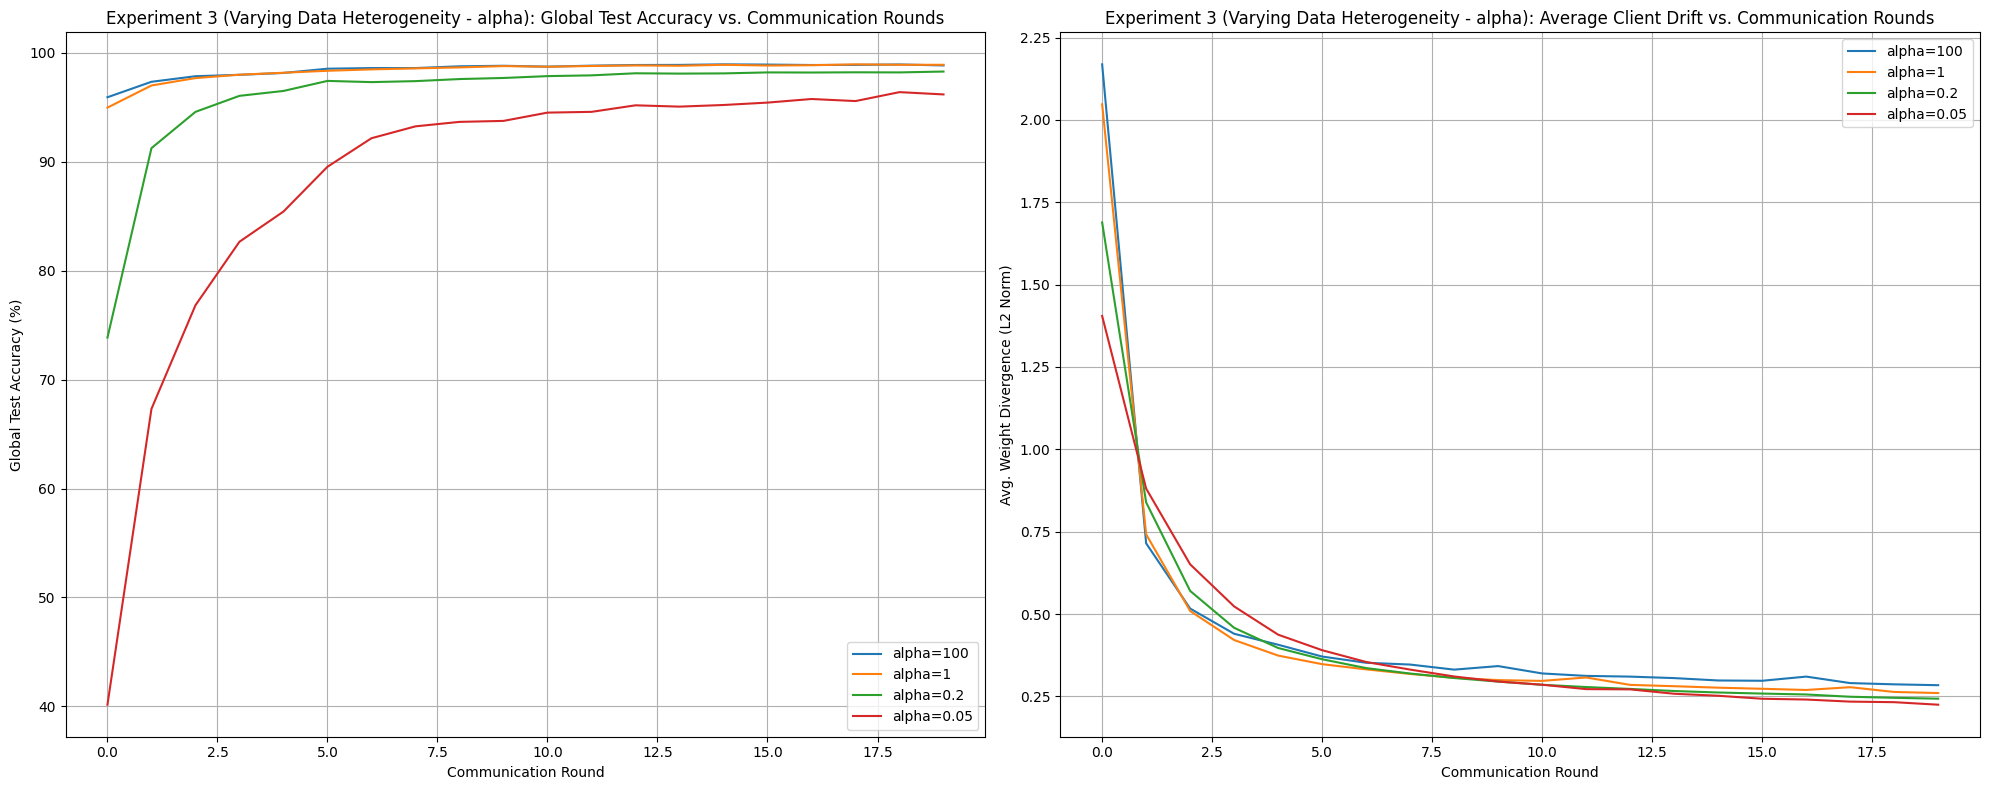

In [16]:
plot_results(results_alpha, "Experiment 3 (Varying Data Heterogeneity - alpha)")